In [1]:
# Run this cell to configure Tensorflow to use your GPU
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
import tensorflow as tf
import tensorflow_hub as hub

# See https://tfhub.dev/ to find other models.
# Average inference time on 24 CPUs = 96 ms
module = 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2'

detector = hub.load(module)

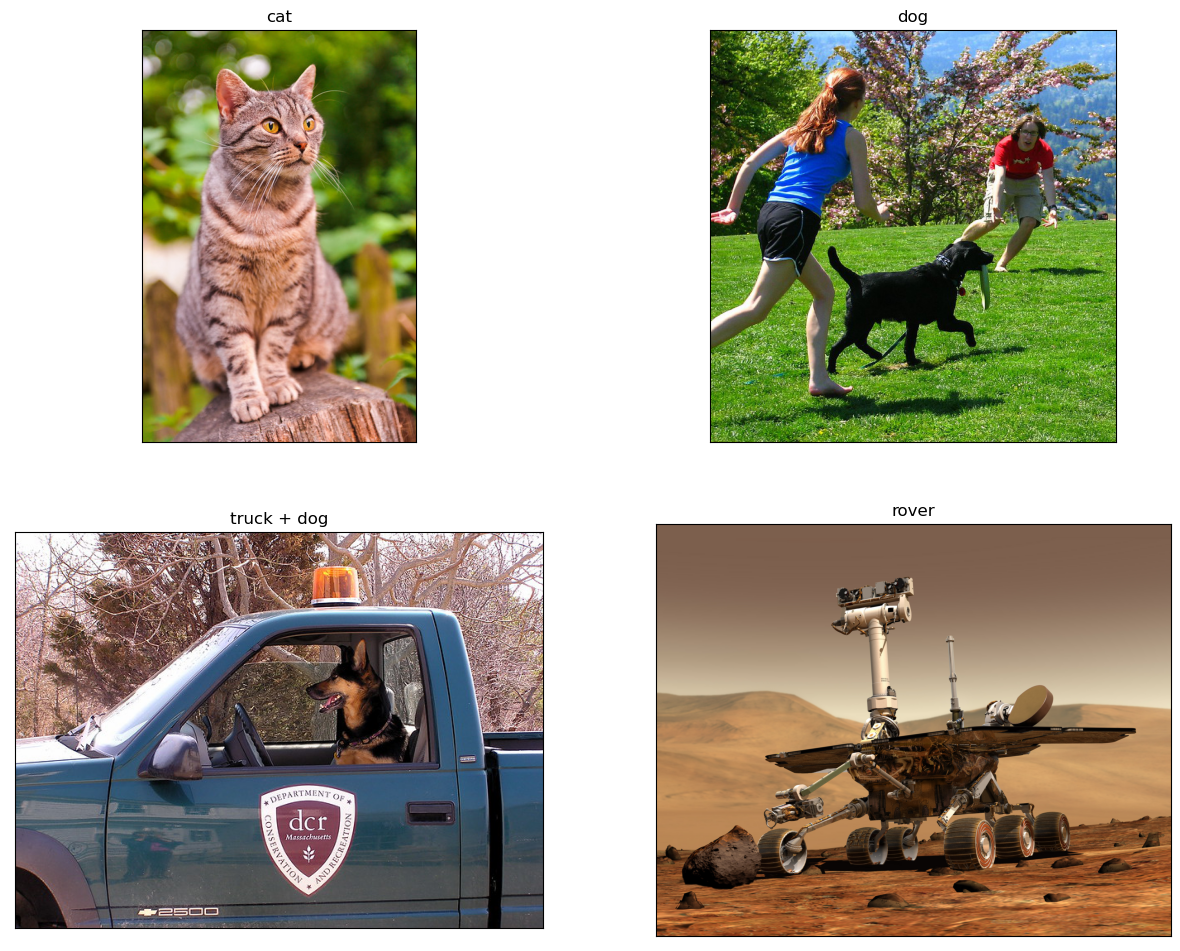

In [3]:
from utils.plot import plot_image, load_tiny_batch, plot_images_grid

# Loads a tiny batch of images from Internet
images_raw = load_tiny_batch()
plot_images_grid(images_raw)

In [24]:
import numpy as np
import pandas as pd

image_input = images_raw['cat']
image_input = np.expand_dims(image_input, 0)

image_input.shape

(1, 640, 427, 3)

In [25]:
%%time

# Running a forward pass through the network with the input image.
result_out = detector(image_input)

CPU times: user 86.7 ms, sys: 28.1 ms, total: 115 ms
Wall time: 38.7 ms


In [26]:
# The result is a dictionary of tensors, so let's look at the shapes.
{name: r.shape for name, r in result_out.items()}

{'detection_multiclass_scores': TensorShape([1, 100, 91]),
 'detection_classes': TensorShape([1, 100]),
 'num_detections': TensorShape([1]),
 'detection_boxes': TensorShape([1, 100, 4]),
 'raw_detection_boxes': TensorShape([1, 1917, 4]),
 'detection_scores': TensorShape([1, 100]),
 'raw_detection_scores': TensorShape([1, 1917, 91]),
 'detection_anchor_indices': TensorShape([1, 100])}

In [27]:
# We need to load a mapping between integer class IDs and English labels.
# There is a helper function in utils folder to do just that.
# Note that integer IDs are in range [1, 90] but there are only 80 classes in MS COCO dataset.

from utils.mscoco import load_class_map
class_map = load_class_map()
class_map

,label
id,
1,person
2,bicycle
3,car
4,motorcycle
5,airplane
...,...
86,vase
87,scissors
88,teddy bear


In [28]:
# Now we can use the data frame from above to convert
# the model output (integer IDs) to the corresponding English labels.
class_ids = result_out['detection_classes'][0].numpy().astype(int)
class_labels = class_map.loc[class_ids].reset_index(drop=True)
class_scores = pd.Series(result_out['detection_scores'][0].numpy()).rename('score')

class_predictions = pd.concat([class_labels, class_scores], axis=1)
class_predictions = class_predictions.sort_values('score', ascending=False)

class_predictions.head(5)

,label,score
0,cat,0.843820
1,bench,0.238308
2,dog,0.228259
3,bench,0.210737
4,apple,0.210514


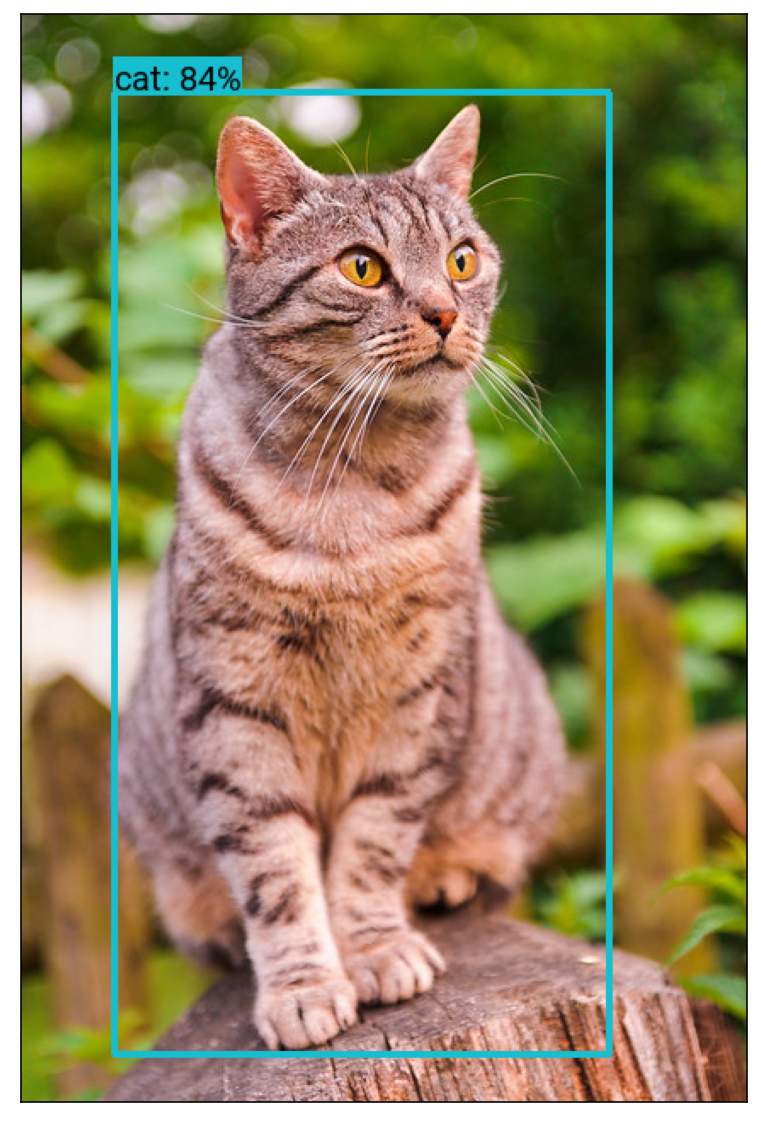

In [29]:
from utils.plot import draw_boxes, plot_image
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

image_with_boxes = draw_boxes(
    np.array(image_input[0]), 
    result_out["detection_boxes"][0],
    class_labels.label.values,
    result_out["detection_scores"][0],
    min_score=0.25
)

plt.figure(figsize=[10, 10])
plot_image(image_with_boxes)